In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import breaks_cusumolsresid
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.dates as mdates
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
from statsmodels.stats.diagnostic import het_white

# Data import and cleaning

In [22]:
df_inflation = pd.read_excel('inflation T10YIE.xlsx', sheet_name="Daily")
df_unemployment = pd.read_excel('unemployment LNU04032232.xlsx', sheet_name="Monthly")
df_gdp = pd.read_excel('gdp BBKMGDP.xlsx', sheet_name="Monthly")

In [23]:
df_inflation

,observation_date,T10YIE
0,2019-12-27,1.73
1,2019-12-30,1.75
2,2019-12-31,1.77
3,2020-01-01,NaN
4,2020-01-02,1.80
...,...,...
1301,2024-12-23,2.32
1302,2024-12-24,2.35
1303,2024-12-25,NaN
1304,2024-12-26,2.35


In [24]:
df_inflation_clean = df_inflation.dropna()
df_inflation_clean

,observation_date,T10YIE
0,2019-12-27,1.73
1,2019-12-30,1.75
2,2019-12-31,1.77
4,2020-01-02,1.80
5,2020-01-03,1.77
...,...,...
1300,2024-12-20,2.29
1301,2024-12-23,2.32
1302,2024-12-24,2.35
1304,2024-12-26,2.35


In [25]:
df_unemployment

,observation_date,LNU04032232
0,2000-01-01,3.6
1,2000-02-01,3.4
2,2000-03-01,3.6
3,2000-04-01,3.7
4,2000-05-01,3.4
...,...,...
294,2024-07-01,3.6
295,2024-08-01,3.5
296,2024-09-01,3.2
297,2024-10-01,3.6


In [26]:
df_gdp

,observation_date,BBKMGDP
0,1960-01-01,15.782813
1,1960-02-01,5.851021
2,1960-03-01,-4.518702
3,1960-04-01,-3.703784
4,1960-05-01,-3.380283
...,...,...
772,2024-05-01,3.770321
773,2024-06-01,3.411649
774,2024-07-01,3.297232
775,2024-08-01,2.794035


In [27]:
df_inflation_clean['observation_date'] = pd.to_datetime(df_inflation_clean['observation_date'])
df_unemployment['observation_date'] = pd.to_datetime(df_unemployment['observation_date'])
df_gdp['observation_date'] = pd.to_datetime(df_gdp['observation_date'])


C:\Users\Charu\AppData\Local\Temp\ipykernel_37164\119798907.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inflation_clean['observation_date'] = pd.to_datetime(df_inflation_clean['observation_date'])


# Combined data monthwise

In [28]:
df_inflation_clean['year_month'] = df_inflation_clean['observation_date'].dt.to_period('M')
df_unemployment['year_month'] = df_unemployment['observation_date'].dt.to_period('M')
df_gdp['year_month'] = df_gdp['observation_date'].dt.to_period('M')


C:\Users\Charu\AppData\Local\Temp\ipykernel_37164\3589919121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inflation_clean['year_month'] = df_inflation_clean['observation_date'].dt.to_period('M')


In [29]:
df_inflation_month = df_inflation_clean.groupby('year_month').first().reset_index()
df_inflation_month

,year_month,observation_date,T10YIE
0,2019-12,2019-12-27,1.73
1,2020-01,2020-01-02,1.80
2,2020-02,2020-02-03,1.63
3,2020-03,2020-03-02,1.41
4,2020-04,2020-04-01,0.91
...,...,...,...
56,2024-08,2024-08-01,2.20
57,2024-09,2024-09-03,2.11
58,2024-10,2024-10-01,2.19
59,2024-11,2024-11-01,2.33


In [30]:
df_final = df_inflation_month.merge(right=df_unemployment,on='year_month',how='left')
df_final = df_final.merge(right=df_gdp,on='year_month',how='left')
df_final

,year_month,observation_date_x,T10YIE,observation_date_y,LNU04032232,observation_date,BBKMGDP
0,2019-12,2019-12-27,1.73,2019-12-01,2.7,2019-12-01,4.958026
1,2020-01,2020-01-02,1.80,2020-01-01,3.4,2020-01-01,1.415004
2,2020-02,2020-02-03,1.63,2020-02-01,3.9,2020-02-01,-12.221101
3,2020-03,2020-03-02,1.41,2020-03-01,4.1,2020-03-01,-44.117700
4,2020-04,2020-04-01,0.91,2020-04-01,13.2,2020-04-01,-71.748129
...,...,...,...,...,...,...,...
56,2024-08,2024-08-01,2.20,2024-08-01,3.5,2024-08-01,2.794035
57,2024-09,2024-09-03,2.11,2024-09-01,3.2,2024-09-01,1.167533
58,2024-10,2024-10-01,2.19,2024-10-01,3.6,NaT,NaN
59,2024-11,2024-11-01,2.33,2024-11-01,3.4,NaT,NaN


In [31]:
df_final.columns

Index(['year_month', 'observation_date_x', 'T10YIE', 'observation_date_y',
       'LNU04032232', 'observation_date', 'BBKMGDP'],
      dtype='object')

In [32]:
df_final.drop(columns=['observation_date_x', 'observation_date_y', 'observation_date'], inplace=True)
df_final

,year_month,T10YIE,LNU04032232,BBKMGDP
0,2019-12,1.73,2.7,4.958026
1,2020-01,1.80,3.4,1.415004
2,2020-02,1.63,3.9,-12.221101
3,2020-03,1.41,4.1,-44.117700
4,2020-04,0.91,13.2,-71.748129
...,...,...,...,...
56,2024-08,2.20,3.5,2.794035
57,2024-09,2.11,3.2,1.167533
58,2024-10,2.19,3.6,NaN
59,2024-11,2.33,3.4,NaN


In [33]:
df_final = df_final.fillna(method='ffill')

C:\Users\Charu\AppData\Local\Temp\ipykernel_37164\3895857319.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final = df_final.fillna(method='ffill')


In [34]:
df_final

,year_month,T10YIE,LNU04032232,BBKMGDP
0,2019-12,1.73,2.7,4.958026
1,2020-01,1.80,3.4,1.415004
2,2020-02,1.63,3.9,-12.221101
3,2020-03,1.41,4.1,-44.117700
4,2020-04,0.91,13.2,-71.748129
...,...,...,...,...
56,2024-08,2.20,3.5,2.794035
57,2024-09,2.11,3.2,1.167533
58,2024-10,2.19,3.6,1.167533
59,2024-11,2.33,3.4,1.167533


In [35]:
df_final.rename(columns={
    'year_month': 'year_month',
    'T10YIE': 'inflation',
    'LNU04032232': 'unemp_rate',
    'BBKMGDP': 'real gdp growth rate'
}, inplace=True)
df_final

,year_month,inflation,unemp_rate,real gdp growth rate
0,2019-12,1.73,2.7,4.958026
1,2020-01,1.80,3.4,1.415004
2,2020-02,1.63,3.9,-12.221101
3,2020-03,1.41,4.1,-44.117700
4,2020-04,0.91,13.2,-71.748129
...,...,...,...,...
56,2024-08,2.20,3.5,2.794035
57,2024-09,2.11,3.2,1.167533
58,2024-10,2.19,3.6,1.167533
59,2024-11,2.33,3.4,1.167533


# Analysis

### Graphs

In [36]:
df_final.columns

Index(['year_month', 'inflation', 'unemp_rate', 'real gdp growth rate'], dtype='object')

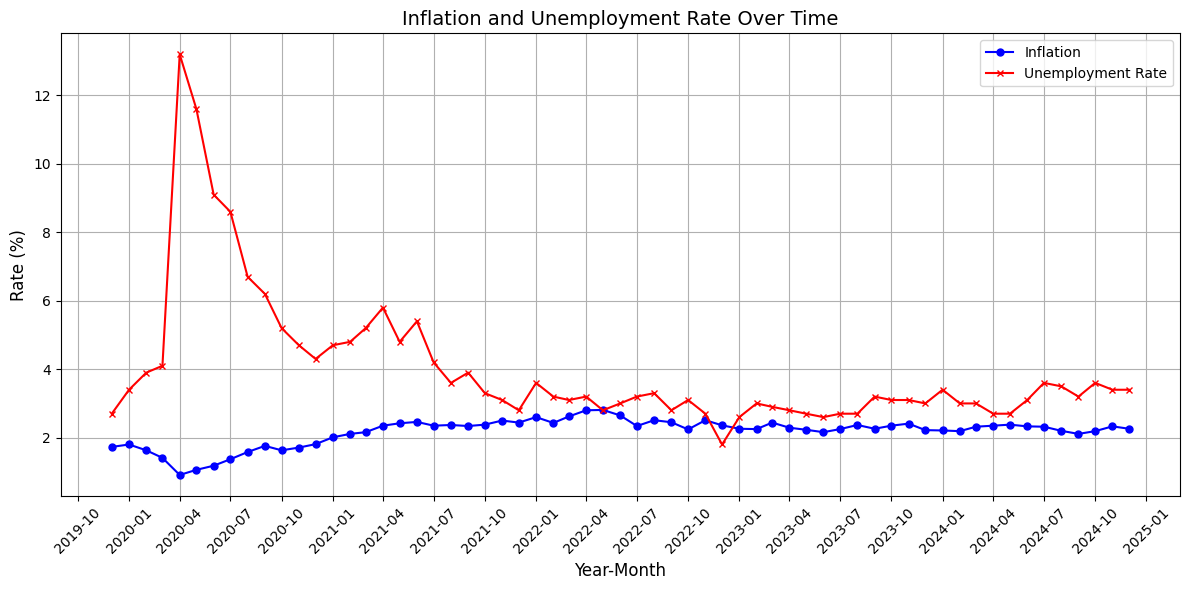

In [141]:
x_axis_year = df_final['year_month'].dt.to_timestamp()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot inflation over time
plt.plot(x_axis_year, df_final['inflation'], label='Inflation', color='blue', marker='o', linestyle='-', markersize=5)

# Plot unemployment rate over time
plt.plot(x_axis_year, df_final['unemp_rate'], label='Unemployment Rate', color='red', marker='x', linestyle='-', markersize=5)

# Set title and labels
plt.title('Inflation and Unemployment Rate Over Time', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Rate (%)', fontsize=12)

# Set x-axis format and tick locator
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))  # Show one label per year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the date as Year-Month

# Add grid and legend
plt.grid(True)
plt.legend()

# Adjust layout to prevent label clipping
plt.tight_layout()

# Show the plot
plt.show()

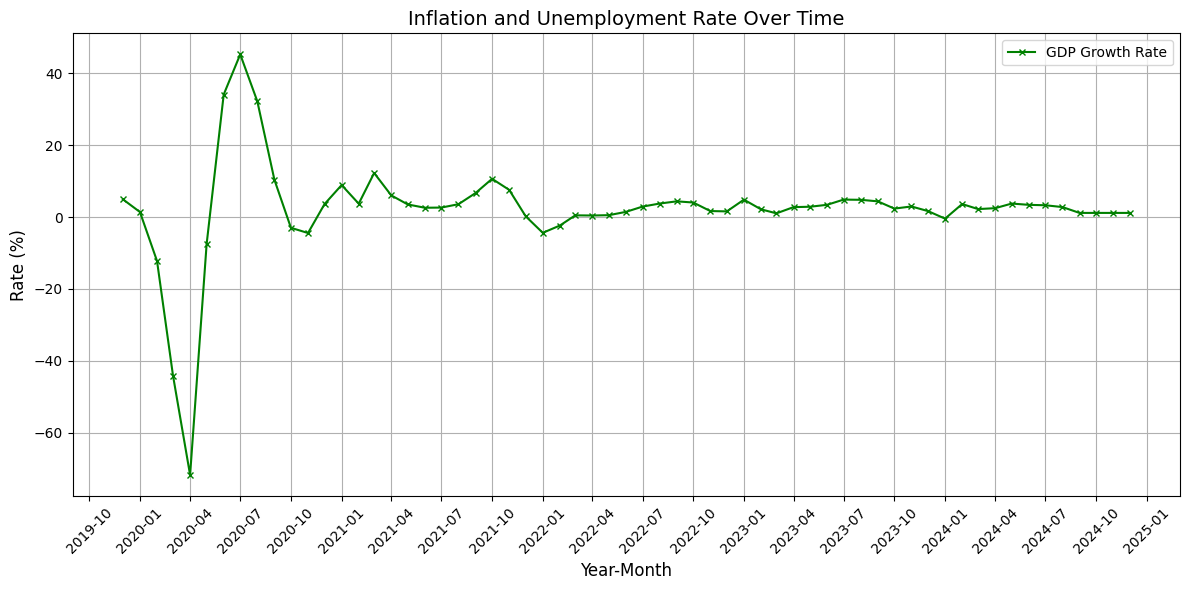

In [ ]:
x_axis_year = df_final['year_month'].dt.to_timestamp()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot unemployment rate over time
plt.plot(x_axis_year, df_final['real gdp growth rate'], label='GDP Growth Rate', color='green', marker='x', linestyle='-', markersize=5)

# Set title and labels
plt.title('Real GDP Growth Rate Over Time', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Rate (%)', fontsize=12)

# Set x-axis format and tick locator
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))  # Show one label per year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the date as Year-Month

# Add grid and legend
plt.grid(True)
plt.legend()

# Adjust layout to prevent label clipping
plt.tight_layout()

# Show the plot
plt.show()

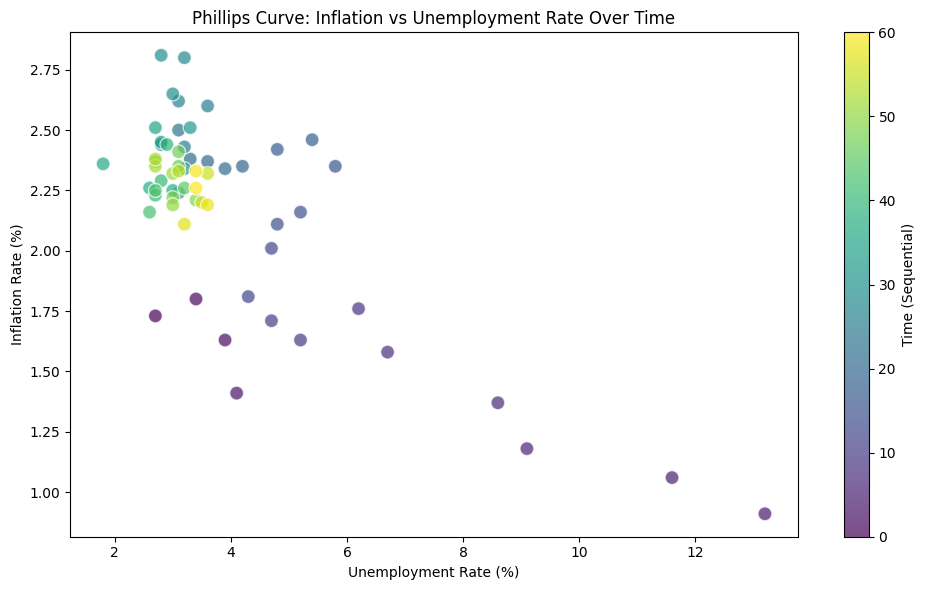

In [38]:
# Plot the Phillips Curve: Unemployment vs Inflation
plt.figure(figsize=(10, 6))

# Scatter plot with time progression mapped to colors based on the reset index
scatter = plt.scatter(df_final['unemp_rate'], df_final['inflation'], 
                      c=df_final.index, cmap='viridis', alpha=0.7, edgecolors='w', s=100)

# Add labels and title
plt.title('Phillips Curve: Inflation vs Unemployment Rate Over Time')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Inflation Rate (%)')

# Add colorbar to show time progression
cbar = plt.colorbar(scatter)
cbar.set_label('Time (Sequential)')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [39]:
print(f"Correlation coefficient: {df_final['inflation'].corr(df_final['unemp_rate'])}")

Correlation coefficient: -0.7730588246112052


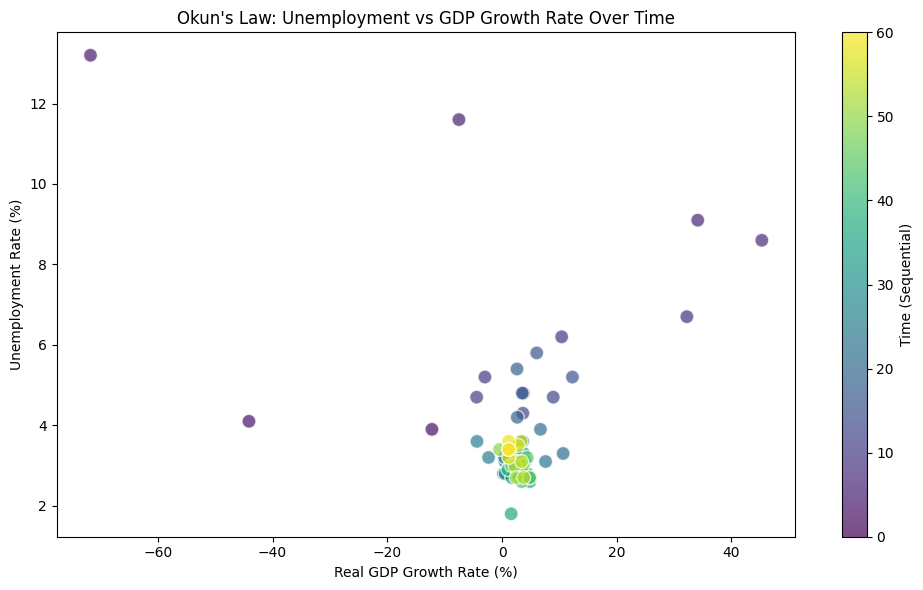

In [66]:
# Plot the Phillips Curve: Unemployment vs Inflation
plt.figure(figsize=(10, 6))

# Scatter plot with time progression mapped to colors based on the reset index
scatter = plt.scatter(df_final['real gdp growth rate'], df_final['unemp_rate'], 
                      c=df_final.index, cmap='viridis', alpha=0.7, edgecolors='w', s=100)

# Add labels and title
plt.title('Okun\'s Law: Unemployment vs GDP Growth Rate Over Time')
plt.xlabel('Real GDP Growth Rate (%)')
plt.ylabel('Unemployment Rate (%)')

# Add colorbar to show time progression
cbar = plt.colorbar(scatter)
cbar.set_label('Time (Sequential)')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [67]:
print(f"Correlation coefficient: {df_final['unemp_rate'].corr(df_final['real gdp growth rate'])}")

Correlation coefficient: -0.17032947265871426


### Regression

In [40]:
df_final

,year_month,inflation,unemp_rate,real gdp growth rate
0,2019-12,1.73,2.7,4.958026
1,2020-01,1.80,3.4,1.415004
2,2020-02,1.63,3.9,-12.221101
3,2020-03,1.41,4.1,-44.117700
4,2020-04,0.91,13.2,-71.748129
...,...,...,...,...
56,2024-08,2.20,3.5,2.794035
57,2024-09,2.11,3.2,1.167533
58,2024-10,2.19,3.6,1.167533
59,2024-11,2.33,3.4,1.167533


In [46]:
scaler = StandardScaler()
df_final_scaled = df_final.copy()  # Create a copy to preserve original data
df_final_scaled[['inflation', 'unemp_rate', 'real gdp growth rate']] = scaler.fit_transform(df_final_scaled[['inflation', 'unemp_rate', 'real gdp growth rate']])

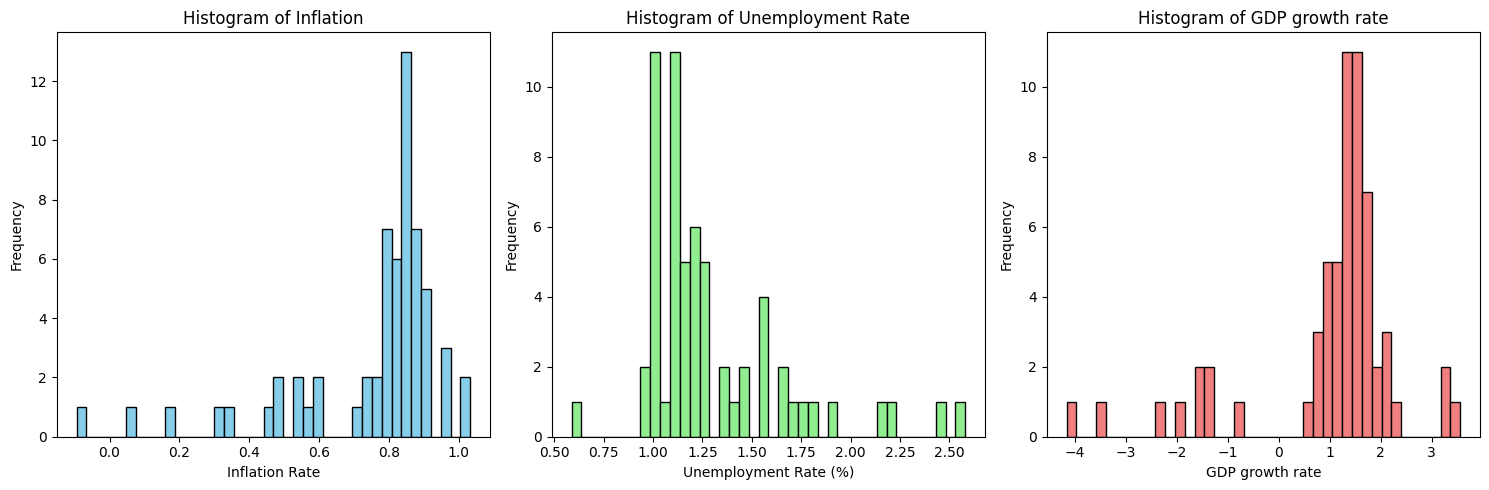

In [144]:
# Create a figure and axis for multiple subplots
plt.figure(figsize=(15, 5))

# Plot histogram for inflation
plt.subplot(1, 3, 1)  # (rows, cols, position)
plt.hist(df_final['inflation'].apply(lambda x: np.log(x)), bins=40, color='skyblue', edgecolor='black')
plt.title('Histogram of Inflation')
plt.xlabel('Inflation Rate')
plt.ylabel('Frequency')

# Plot histogram for unemployment rate
plt.subplot(1, 3, 2)
plt.hist(df_final['unemp_rate'].apply(lambda x: np.log(x)), bins=40, color='lightgreen', edgecolor='black')
plt.title('Histogram of Unemployment Rate')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Frequency')

# Plot histogram for GDP
plt.subplot(1, 3, 3)
plt.hist(df_final['real gdp growth rate'].apply(lambda x: np.cbrt(x)), bins=40, color='lightcoral', edgecolor='black')
plt.title('Histogram of GDP growth rate')
plt.xlabel('GDP growth rate')
plt.ylabel('Frequency')

# Adjust the layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [54]:
X = df_final_scaled[['inflation', 'unemp_rate', 'real gdp growth rate']]

# Add a constant to the model (this represents the intercept term in the regression)
X = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif_data)

                Feature       VIF
0                 const  1.000000
1             inflation  2.503538
2            unemp_rate  2.489952
3  real gdp growth rate  1.037473


#### Model 1 - Unemp and inflation

In [97]:
model_1 = sm.OLS(df_final['unemp_rate'].apply(np.log), sm.add_constant(df_final['inflation'].apply(np.log))).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:             unemp_rate   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     92.44
Date:                Sun, 05 Jan 2025   Prob (F-statistic):           1.10e-13
Time:                        16:32:55   Log-Likelihood:                 2.8459
No. Observations:                  61   AIC:                            -1.692
Df Residuals:                      59   BIC:                             2.530
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2850      0.106     21.470      0.0

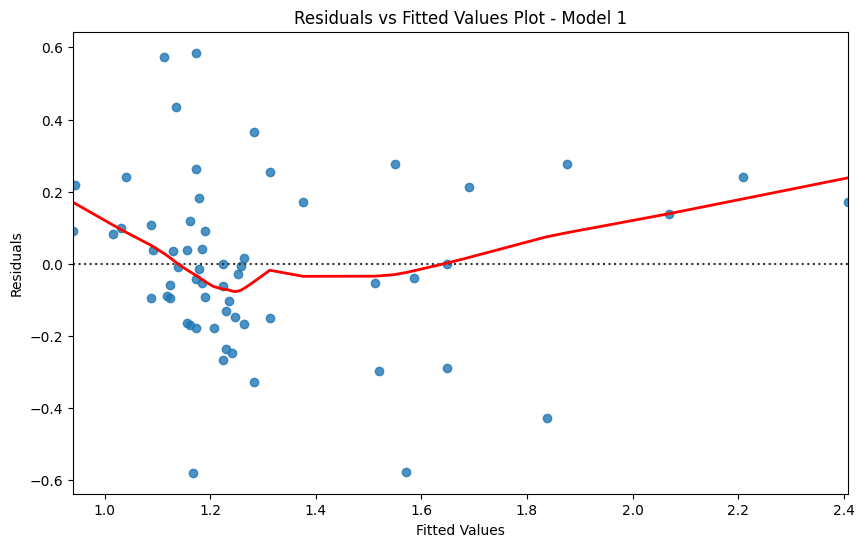

Breusch-Pagan test statistic: 0.44907518350070286
p-value: 0.5027744624352932
White test statistic: 1.3047623568219453
p-value: 0.520804171456386


In [119]:
# Get residuals and fitted values
residuals = model_1.resid
fitted = model_1.fittedvalues

# Create the residuals vs fitted plot
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values Plot - Model 1')
plt.show()

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(model_1.resid, model_1.model.exog)

# bp_test returns (Lagrange Multiplier statistic, p-value, f-statistic, f-test p-value)
lm_statistic, lm_p_value = bp_test[0], bp_test[1]

print(f"Breusch-Pagan test statistic: {lm_statistic}")
print(f"p-value: {lm_p_value}")
# Perform White's test
white_test = het_white(model_1.resid, model_1.model.exog)

# White test returns test statistic and p-value
white_statistic, white_p_value = white_test[0], white_test[1]

print(f"White test statistic: {white_statistic}")
print(f"p-value: {white_p_value}")

#### Model 2

In [151]:
model_2 = sm.OLS(df_final['real gdp growth rate'].apply(np.cbrt), sm.add_constant(df_final['unemp_rate'].apply(np.log))).fit()
print(model_2.summary())

                             OLS Regression Results                             
Dep. Variable:     real gdp growth rate   R-squared:                       0.042
Model:                              OLS   Adj. R-squared:                  0.026
Method:                   Least Squares   F-statistic:                     2.604
Date:                  Sun, 05 Jan 2025   Prob (F-statistic):              0.112
Time:                          23:41:54   Log-Likelihood:                -107.73
No. Observations:                    61   AIC:                             219.5
Df Residuals:                        59   BIC:                             223.7
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0601      0.675

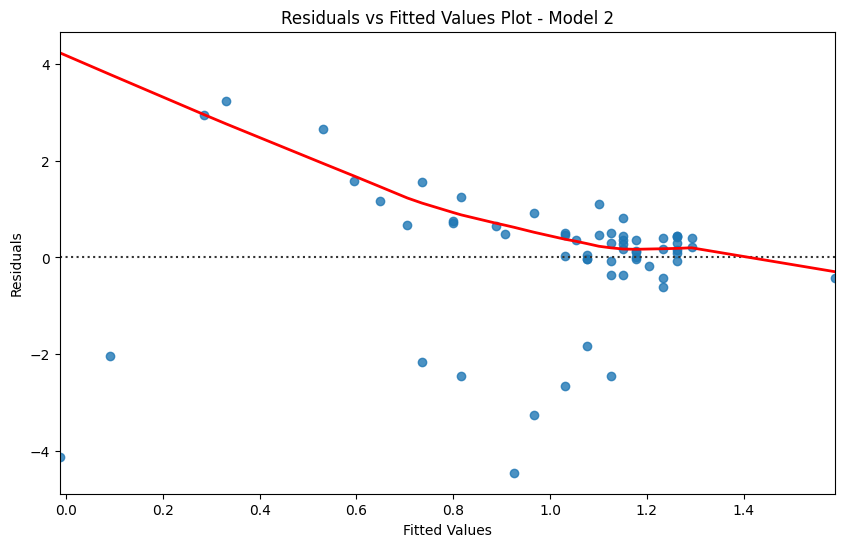

Breusch-Pagan test statistic: 22.281972250773663
p-value: 2.354063026851175e-06
White test statistic: 23.136467607068035
p-value: 9.461933550701273e-06


In [152]:
# Get residuals and fitted values
residuals = model_2.resid
fitted = model_2.fittedvalues

# Create the residuals vs fitted plot
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values Plot - Model 2')
plt.show()

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(model_2.resid, model_2.model.exog)

# bp_test returns (Lagrange Multiplier statistic, p-value, f-statistic, f-test p-value)
lm_statistic, lm_p_value = bp_test[0], bp_test[1]

print(f"Breusch-Pagan test statistic: {lm_statistic}")
print(f"p-value: {lm_p_value}")

# Perform White's test
white_test = het_white(model_2.resid, model_2.model.exog)

# White test returns test statistic and p-value
white_statistic, white_p_value = white_test[0], white_test[1]

print(f"White test statistic: {white_statistic}")
print(f"p-value: {white_p_value}")

#### Model 3

In [146]:
model_3 = sm.OLS(df_final['real gdp growth rate'].apply(np.cbrt), sm.add_constant(df_final[['inflation', 'unemp_rate']].apply(np.log))).fit()
print(model_3.summary())

                             OLS Regression Results                             
Dep. Variable:     real gdp growth rate   R-squared:                       0.157
Model:                              OLS   Adj. R-squared:                  0.128
Method:                   Least Squares   F-statistic:                     5.413
Date:                  Sun, 05 Jan 2025   Prob (F-statistic):            0.00699
Time:                          21:57:32   Log-Likelihood:                -103.83
No. Observations:                    61   AIC:                             213.7
Df Residuals:                        58   BIC:                             220.0
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7705      1.832

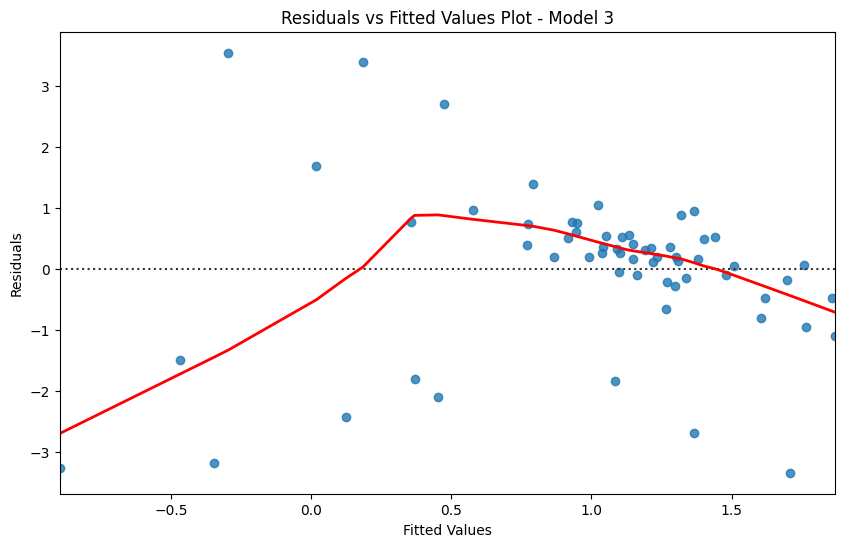

Breusch-Pagan test statistic: 27.387640540635335
p-value: 1.129404257157098e-06
White test statistic: 30.833291351109626
p-value: 1.0104597381573044e-05


In [147]:
# Get residuals and fitted values
residuals = model_3.resid
fitted = model_3.fittedvalues

# Create the residuals vs fitted plot
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values Plot - Model 3')
plt.show()

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(model_3.resid, model_3.model.exog)

# bp_test returns (Lagrange Multiplier statistic, p-value, f-statistic, f-test p-value)
lm_statistic, lm_p_value = bp_test[0], bp_test[1]

print(f"Breusch-Pagan test statistic: {lm_statistic}")
print(f"p-value: {lm_p_value}")

# Perform White's test
white_test = het_white(model_3.resid, model_3.model.exog)

# White test returns test statistic and p-value
white_statistic, white_p_value = white_test[0], white_test[1]

print(f"White test statistic: {white_statistic}")
print(f"p-value: {white_p_value}")